In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from matplotlib import rcParams
from datetime import datetime
startTime = datetime.now()
import os
import scipy.io as sio

import seaborn as sns
import random as rd
import sys, os

import matplotlib.cm as cm
import matplotlib as mpl


from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from numpy.testing import assert_array_almost_equal

from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import warnings
warnings.filterwarnings('ignore')

viridis_cmap = plt.get_cmap('viridis')
num_colors = 8
viridis_colors = [mcolors.to_hex(viridis_cmap(i / (num_colors - 1))) for i in range(num_colors)]
print(viridis_colors)

font = {'family': 'Arial',
        'color':  'black',
        'weight': 'normal',
        'size': 12}
plt.rcParams.update(plt.rcParamsDefault)
plt.rc('font',family='Arial')

['#440154', '#46327e', '#365c8d', '#277f8e', '#1fa187', '#4ac16d', '#a0da39', '#fde725']


In [24]:
df_sesLA_raw = pd.read_csv('df_sesLA.csv')
df_evseLA_raw=pd.read_csv('df_evseLA.csv')
df_sesLA_raw = pd.merge(df_sesLA_raw, df_evseLA_raw, on='evse_id', how='left')
# df_sesLA_raw = pd.read_csv('scripts/df_sesLA.csv')

# main quest: plot kernel density (smoothed histogram, area under curve = 1 normalization)
# of charging session start and end times

# drop all NA value rows
# df_sesLA_raw.dropna(inplace=True) # DROP NA? NO NO NO
df_sesLA = df_sesLA_raw[df_sesLA_raw['flag_id'] == 0]

df_sesLA.loc[:, 'start_datetime_2'] = pd.to_datetime(df_sesLA['start_datetime'], format='%Y-%m-%d %H:%M:%S.%f')
df_sesLA.loc[:, 'end_datetime_2'] = pd.to_datetime(df_sesLA['end_datetime'], format='%Y-%m-%d %H:%M:%S.%f')

# convert minutes to decimal hours
df_sesLA.loc[:, 'start_time_2'] = df_sesLA['start_datetime_2'].dt.hour + df_sesLA['start_datetime_2'].dt.minute/60
df_sesLA.loc[:, 'end_time_2'] = df_sesLA['end_datetime_2'].dt.hour + df_sesLA['end_datetime_2'].dt.minute/60

In [25]:
count = df_sesLA['start_soc'].isna().sum()
print(count)
print(df_sesLA.shape)

8521
(341219, 22)


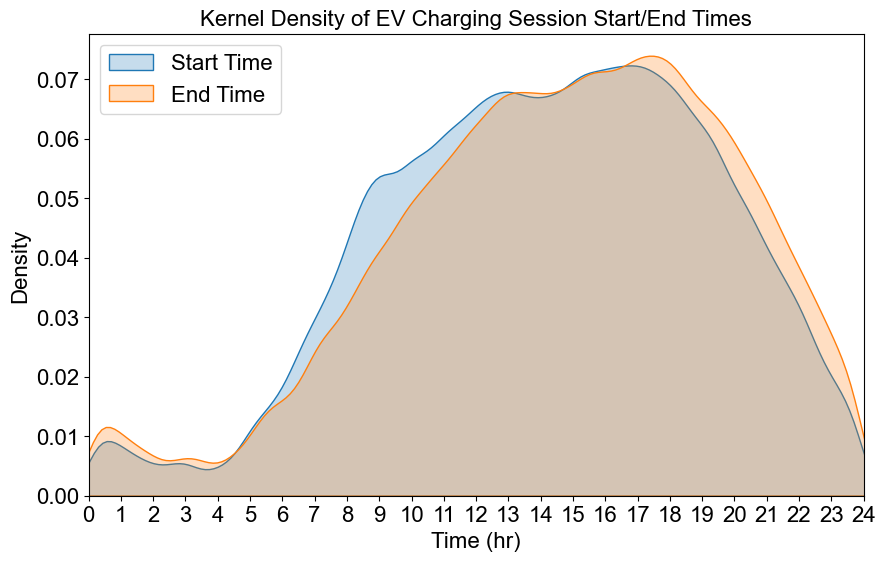

In [26]:
plt.figure(figsize=(10, 6))
sns.kdeplot(df_sesLA['start_time_2'], label='Start Time', fill=True)
sns.kdeplot(df_sesLA['end_time_2'], label='End Time', fill=True)
plt.xlabel('Time (hr)', fontsize=16)
plt.ylabel('Density', fontsize=16)
plt.title('Kernel Density of EV Charging Session Start/End Times', fontsize=16)
plt.xlim(0, 24)
plt.xticks(np.arange(0, 25, step=1))
plt.legend(fontsize=16, loc='upper left')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.savefig('figure3.2.png')
plt.show()

In [27]:
original_index = df_sesLA.index.copy()

In [28]:
original_index.shape

(341219,)

In [29]:
df_sesLA.loc[:, 'start_time_3'] = (df_sesLA['start_time_2'] / 0.1).round() * 0.1
df_sesLA.loc[:, 'end_time_3'] = (df_sesLA['end_time_2'] / 0.1).round() * 0.1
print(df_sesLA.dtypes)

# # 24 hr , 1 hr encoding
# hours = list(range(25))
# def encode_hours(row):
#     return [(row['start_time_3'] <= hour) & (hour < row['end_time_3']) for hour in hours]
# df_sesLA_bool = pd.DataFrame(df_sesLA.apply(encode_hours, axis=1).tolist(), columns=[f'hour_{hour}' for hour in hours])
# df_sesLA_enco = df_sesLA_bool.astype(int)

# 24 hr , 0.1 hr encoding
hours = [round(x * 0.1, 1) for x in range(250)]
def encode_hours(row):
    return [row['start_time_3'] <= t <= row['end_time_3'] for t in hours]

df_sesLA_bool = pd.DataFrame(df_sesLA.apply(encode_hours, axis=1).tolist(), columns=[f'time_{t}' for t in hours])
df_sesLA_enco = df_sesLA_bool.astype(int)
df_sesLA_enco.index = original_index

session_id                   int64
evse_id                      int64
connector_id                 int64
start_datetime              object
end_datetime                object
total_duration             float64
charge_duration            float64
energy_kwh                 float64
start_soc                  float64
end_soc                    float64
flag_id                      int64
metro_area                  object
land_use                    object
region                      object
num_ports                    int64
charge_level                object
venue                       object
pricing                     object
start_datetime_2    datetime64[ns]
end_datetime_2      datetime64[ns]
start_time_2               float64
end_time_2                 float64
start_time_3               float64
end_time_3                 float64
dtype: object


In [30]:

# BRUT FORCE STANDARDIZATION for additional parameters
# (needed before PCA for continuous variables with asymmetric raw distributions)
scaler = StandardScaler()

total_duration_column = df_sesLA['total_duration']
total_duration_column_reshaped = total_duration_column.values.reshape(-1, 1)
total_duration_standardized = scaler.fit_transform(total_duration_column_reshaped)
total_duration_standardized_df = pd.DataFrame(total_duration_standardized, columns=['total_duration_standardized'])
total_duration_standardized_df.index= original_index
df_sesLA_enco = pd.concat([df_sesLA_enco, total_duration_standardized_df], axis=1)

total_duration_column = df_sesLA['charge_duration']
total_duration_column_reshaped = total_duration_column.values.reshape(-1, 1)
total_duration_standardized = scaler.fit_transform(total_duration_column_reshaped)
total_duration_standardized_df = pd.DataFrame(total_duration_standardized, columns=['charge_duration_standardized'])
total_duration_standardized_df.index = original_index
df_sesLA_enco = pd.concat([df_sesLA_enco, total_duration_standardized_df], axis=1)

total_duration_column = df_sesLA['start_soc']
total_duration_column_reshaped = total_duration_column.values.reshape(-1, 1)
total_duration_standardized = scaler.fit_transform(total_duration_column_reshaped)
total_duration_standardized_df = pd.DataFrame(total_duration_standardized, columns=['start_soc_standardized'])
total_duration_standardized_df.index = original_index
df_sesLA_enco = pd.concat([df_sesLA_enco, total_duration_standardized_df], axis=1)

total_duration_column = df_sesLA['end_soc']
total_duration_column_reshaped = total_duration_column.values.reshape(-1, 1)
total_duration_standardized = scaler.fit_transform(total_duration_column_reshaped)
total_duration_standardized_df = pd.DataFrame(total_duration_standardized, columns=['end_soc_standardized'])
total_duration_standardized_df.index = original_index
df_sesLA_enco = pd.concat([df_sesLA_enco, total_duration_standardized_df], axis=1)

# fill in NA valeus w avg val fo col
df_sesLA_enco['total_duration_standardized'] = df_sesLA_enco['total_duration_standardized'].fillna(df_sesLA_enco['total_duration_standardized'].mean())
df_sesLA_enco['charge_duration_standardized'] = df_sesLA_enco['charge_duration_standardized'].fillna(df_sesLA_enco['charge_duration_standardized'].mean())
df_sesLA_enco['start_soc_standardized'] = df_sesLA_enco['start_soc_standardized'].fillna(df_sesLA_enco['start_soc_standardized'].mean())
df_sesLA_enco['end_soc_standardized'] = df_sesLA_enco['end_soc_standardized'].fillna(df_sesLA_enco['end_soc_standardized'].mean())


df_sesLA_venue=df_sesLA['venue']

df_sesLA_venue = pd.get_dummies(df_sesLA_venue, columns=['venue'])
df_sesLA_venue = df_sesLA_venue.astype(int)
df_sesLA_venue.index = original_index
df_sesLA_enco = pd.merge(df_sesLA_enco, df_sesLA_venue, left_index=True, right_index=True, how='left')


df_sesLA_pricing=df_sesLA['pricing']

df_sesLA_pricing = pd.get_dummies(df_sesLA_pricing, columns=['pricing'])
df_sesLA_pricing = df_sesLA_pricing.astype(int)
df_sesLA_pricing.index = original_index
df_sesLA_enco = pd.merge(df_sesLA_enco, df_sesLA_pricing, left_index=True, right_index=True, how='left')



In [31]:
null_counts = df_sesLA_enco.isna().sum()
print(null_counts)

time_0.0               0
time_0.1               0
time_0.2               0
time_0.3               0
time_0.4               0
                      ..
Multi-Unit Dwelling    0
Undesignated_x         0
Free                   0
Paid                   0
Undesignated_y         0
Length: 261, dtype: int64


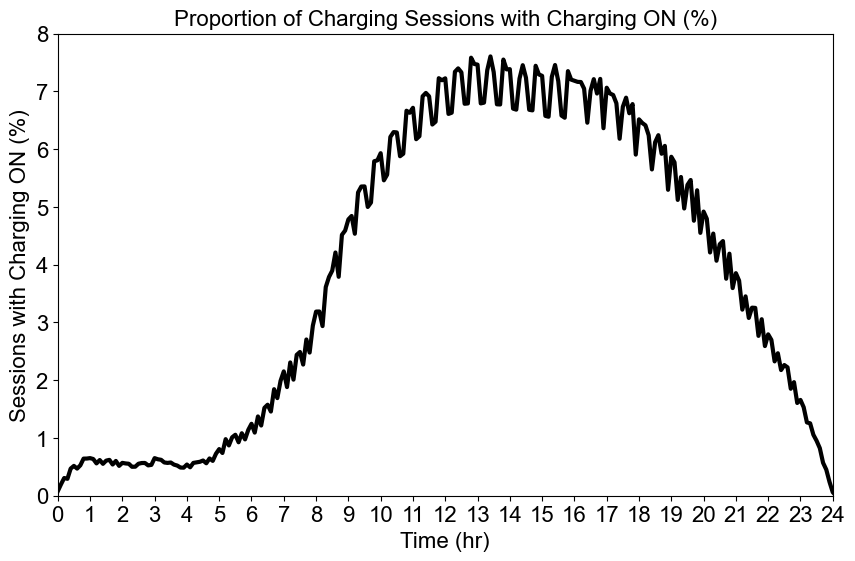

In [32]:
df_sesLA_enco_sums = df_sesLA_enco.sum()
df_sesLA_enco_sums = df_sesLA_enco_sums[:-11]

num_rows_all = df_sesLA.shape[0]
df_sesLA_enco_sums_ntot = df_sesLA_enco_sums.copy()
df_sesLA_enco_sums_ntot /= num_rows_all
df_sesLA_enco_sums_ntot = df_sesLA_enco_sums_ntot*100

plt.figure(figsize=(10, 6))
plt.plot(hours,df_sesLA_enco_sums_ntot, '-', color='#000000', alpha=1, lw = 3)
plt.xlabel('Time (hr)', fontsize=16)
plt.ylabel('Sessions with Charging ON (%)', fontsize=16)
plt.title('Proportion of Charging Sessions with Charging ON (%)', fontsize=16)
plt.xlim(0, 24)
# plt.ylim(0, 0.08)
plt.ylim(0, 8)
plt.xticks(np.arange(0, 25, step=1))
# plt.legend(fontsize=16, loc='upper left')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.savefig('fig4.1.png')
plt.show()

In [33]:
df_sesLA_enco.columns

Index(['time_0.0', 'time_0.1', 'time_0.2', 'time_0.3', 'time_0.4', 'time_0.5',
       'time_0.6', 'time_0.7', 'time_0.8', 'time_0.9',
       ...
       'charge_duration_standardized', 'start_soc_standardized',
       'end_soc_standardized', 'Business Office', 'Corridor',
       'Multi-Unit Dwelling', 'Undesignated_x', 'Free', 'Paid',
       'Undesignated_y'],
      dtype='object', length=261)

# Changed n_components to 254 to add new columns?

In [34]:
pca_all = PCA(n_components=261)
pca_all.fit(df_sesLA_enco)

PCA(n_components=261)

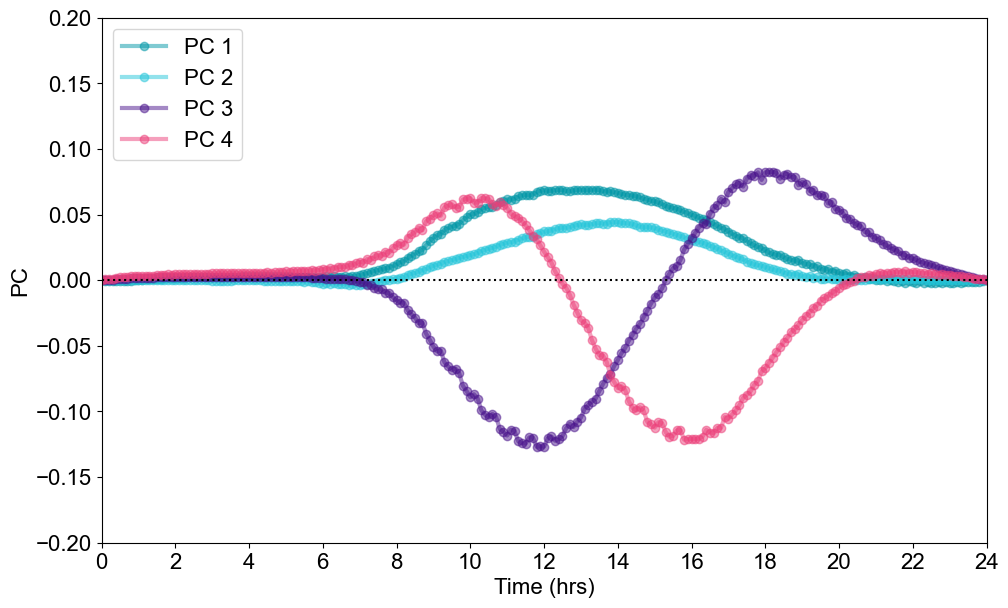

In [35]:
plt.figure(figsize=(10, 6))
plt.plot(hours,pca_all.components_[0,:-11], 'o-', color='#0097A7', alpha=0.5, lw = 3, label = 'PC 1')
plt.plot(hours,pca_all.components_[1,:-11], 'o-', color='#26C6DA', alpha=0.5, lw = 3, label = 'PC 2') # THE GOOD ONE
plt.plot(hours,pca_all.components_[2,:-11], 'o-', color='#4A148C', alpha=0.5, lw = 3, label = 'PC 3')
plt.plot(hours,pca_all.components_[3,:-11], 'o-', color='#EC407A', alpha=0.5, lw = 3, label = 'PC 4')

# plt.plot(hours,pca_all.components_[0,:], 'o-', color='#1A237E', alpha=0.5, lw = 3, label = 'PC 1')
# plt.plot(hours,pca_all.components_[1,:], 'o-', color='#28B463', alpha=0.5, lw = 3, label = 'PC 2') # THE GOOD ONE
# plt.plot(hours,pca_all.components_[2,:], 'o-', color='#303F9F', alpha=0.5, lw = 3, label = 'PC 3')
# plt.plot(hours,pca_all.components_[3,:], 'o-', color='#3F51B5', alpha=0.5, lw = 3, label = 'PC 4')
# plt.plot(hours,pca_all.components_[4,:], 'o-', color='#800080', alpha=0.5, lw = 3, label = 'PC5')
# plt.plot(hours,pca_all.components_[5,:], 'o-', color='#4B0082', alpha=0.5, lw = 3, label = 'PC6')

plt.tight_layout()
plt.legend(loc='upper left', ncol = 1,fontsize=16)
plt.ylim([-0.2, 0.2])
plt.xlim([0,24])
plt.yticks()
plt.yticks(fontsize=16)
plt.xticks(np.arange(0,25,step=2),fontsize=16)
plt.xlabel('Time (hrs)',fontsize=16)
plt.ylabel('PC',fontsize=16)
plt.axhline(y=0, xmin=0, xmax=24, color='black', ls=':')
plt.subplots_adjust(bottom=0.1, left=0.1)
plt.savefig('figure4.3.png')
plt.show()

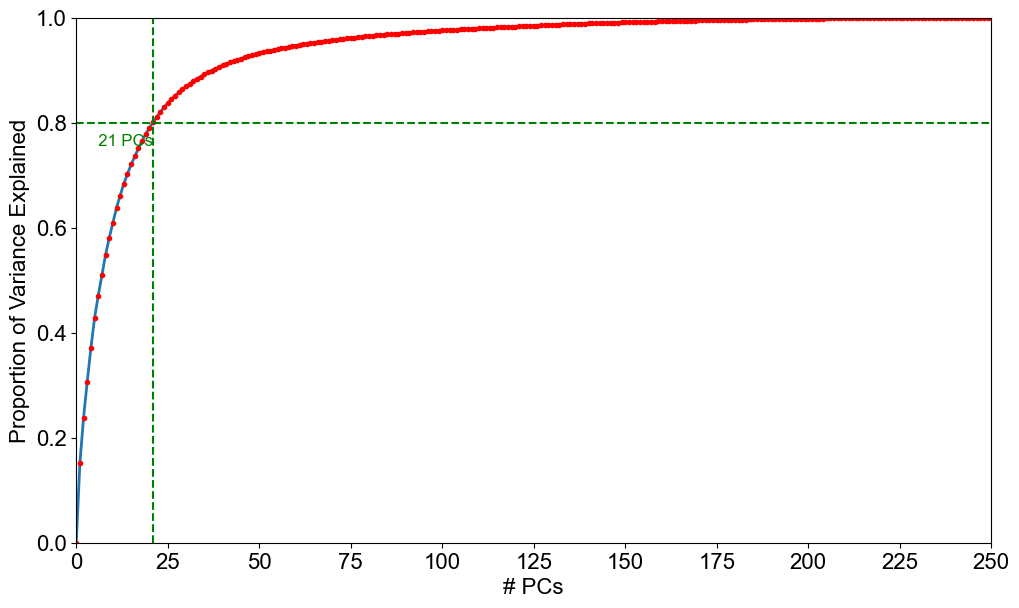

In [36]:
list_variance = pca_all.explained_variance_ratio_
n_components=261

plt.figure(figsize = (10,6))
ax = plt.gca()
plt.plot(range(0,n_components+1), np.cumsum([0] + list(list_variance)), linewidth = 2)
plt.plot(range(0,n_components+1), np.cumsum([0] + list(list_variance)), '.', c='r', markersize=6)

cumulative_variance = np.cumsum(list_variance)
percentage=.8
PC_75var = np.argmax(cumulative_variance >= percentage) + 1
plt.axhline(y=percentage, color='green', linestyle='--', linewidth=1.5, label="75% Variance Explained")
plt.axvline(x=PC_75var, color='green', linestyle='--', linewidth=1.5)

plt.text(PC_75var, 0.75, f'  {PC_75var} PCs', verticalalignment='bottom', horizontalalignment='right', color='green', fontsize=12)
plt.tight_layout()

plt.xlim([0,240])
plt.ylim([0, 1])

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xticks(np.arange(0,251,step=25),fontsize=16)
plt.xlabel('# PCs',fontsize=16)
plt.ylabel('Proportion of Variance Explained',fontsize=16)
plt.subplots_adjust(bottom=0.1, left=0.07)
plt.savefig('figure4.2.png')
plt.show()

# K-means Elbow Plot

Finalize with a larger K. For now assume # of clusters =9

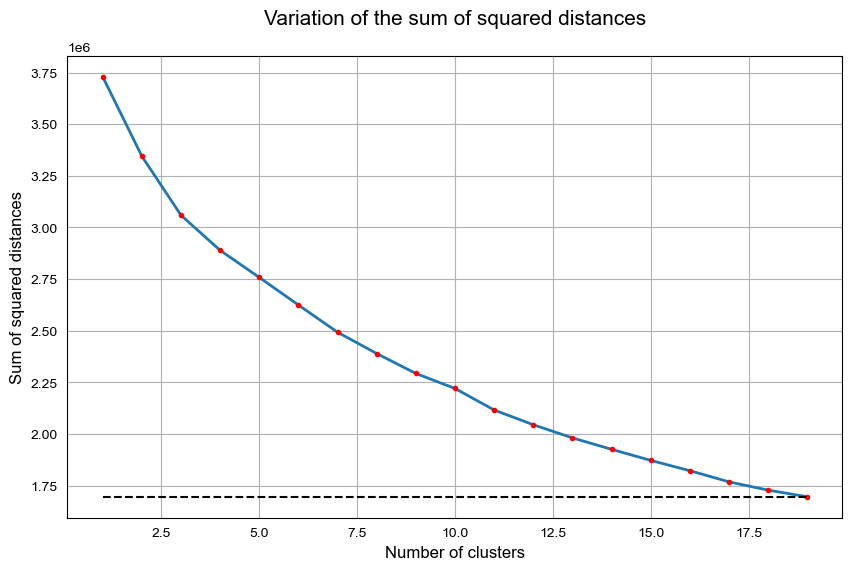

In [37]:

n_select = 21 # NUMBER OF PCS <===============================================================================
pca_k = PCA(n_components = n_select)
pca_k.fit(df_sesLA_enco) # do the PCA
pca_k_proj = pca_k.fit_transform(df_sesLA_enco) # Dot Product of data with PC's
pca_k_reconstr = pca_k.inverse_transform(pca_k.fit_transform(df_sesLA_enco)) # Reconstruct data w selected PC's

Sum_of_squared_distances = []
K = range(1,20)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(pca_k_proj)
    Sum_of_squared_distances.append(km.inertia_)

plt.figure(figsize = (10,6))
ax = plt.gca()
plt.plot(K, Sum_of_squared_distances, linewidth = 2)
plt.plot(K, Sum_of_squared_distances, '.', c='r',markersize = 6)
plt.plot(K, [Sum_of_squared_distances[-1] for i in range(len(Sum_of_squared_distances))], '--',
         linewidth = 1.5, c = 'black')

plt.xlabel('Number of clusters', fontsize = 12)
plt.ylabel('Sum of squared distances', fontsize = 12)
plt.title('Variation of the sum of squared distances', fontsize = 15, y = 1.05)
ax.yaxis.set_ticks_position('none')
ax.xaxis.set_ticks_position('none')
#plt.xticks(np.arange(1, 21, step=1))
ax.grid(True)
plt.savefig('kmeans_elbow.png')
plt.show()


In [38]:
np.random.seed(60527)

k = 12 # NUMBER OF CLUSTERS <==================================================================================

kmeans = KMeans(n_clusters = k,random_state=1)
membership_out = kmeans.fit_predict(pca_k_proj)
Score = kmeans.score(pca_k_proj)
centers = kmeans.cluster_centers_
centers_initial_base = pca_k.inverse_transform(centers)

# SWITCH NAMES
membership = membership_out.copy()
#membership[membership_out == 0] = 3 # 1 third peak 4
#membership[membership_out == 1] = 7                  # 2 beb3 8
#membership[membership_out == 2] = 0 # 3 GOOD GOOD 1
#membership[membership_out == 3] = 5                          # 4 beb1 6
#membership[membership_out == 4] = 4 # 5 fourth peak 5
#membership[membership_out == 5] = 6                              # 6 beb2 7
#membership[membership_out == 6] = 8            # DNE
#membership[membership_out == 7] = 1 # 8 first peak 2
#membership[membership_out == 8] = 2 # 9 second peak 3


print(f'Size df_sesLA: {df_sesLA.shape} (pre id)')
df_sesLA_id = df_sesLA
df_sesLA_id['cluster_id'] = np.array(membership)
print(f'Size df_sesLA: {df_sesLA.shape} (post id)')
print(f'Size df_sesLA_id: {df_sesLA_id.shape} (post id)')

print(f'Size df_sesLA_enco: {df_sesLA_enco.shape} (pre id)')
df_sesLA_enco_id = df_sesLA_enco.copy()
df_sesLA_enco_id['cluster_id'] = np.array(membership)
print(f'Size df_sesLA_enco: {df_sesLA_enco.shape} (post id)')
print(f'Size df_sesLA_enco_id: {df_sesLA_enco_id.shape} (post id)')

N = len(membership)
percentage_list = []
nb_of_people_list = []
for i in range(k):
    percentage_list.append(round(100*(membership== i).sum()/N,2))
    nb_of_people_list.append((membership == i).sum())
    # print("Cluster " + str(i+1) + " captures {:.2f}%".format(percentage_list[-1]),"of sessions")
    print(f'Cluster {str(i + 1)} captures {percentage_list[-1]*N/100} sessions ( {percentage_list[-1]}% )')
projected_data = pca_k_proj
y_km = membership

Size df_sesLA: (341219, 24) (pre id)
Size df_sesLA: (341219, 25) (post id)
Size df_sesLA_id: (341219, 25) (post id)
Size df_sesLA_enco: (341219, 261) (pre id)
Size df_sesLA_enco: (341219, 261) (post id)
Size df_sesLA_enco_id: (341219, 262) (post id)
Cluster 1 captures 57938.9862 sessions ( 16.98% )
Cluster 2 captures 14740.660800000001 sessions ( 4.32% )
Cluster 3 captures 20063.6772 sessions ( 5.88% )
Cluster 4 captures 91105.47299999998 sessions ( 26.7% )
Cluster 5 captures 5254.7726 sessions ( 1.54% )
Cluster 6 captures 18698.8012 sessions ( 5.48% )
Cluster 7 captures 17060.95 sessions ( 5.0% )
Cluster 8 captures 72713.7689 sessions ( 21.31% )
Cluster 9 captures 409.4628 sessions ( 0.12% )
Cluster 10 captures 7029.1114 sessions ( 2.06% )
Cluster 11 captures 18050.4851 sessions ( 5.29% )
Cluster 12 captures 18084.607 sessions ( 5.3% )


# Clusters projected onto PCA 1 & 2

In [2]:
projected_data = pca_k_proj
y_km = membership

plt.figure(figsize=(10, 6))

# Generate a color palette that can dynamically adjust to the number of clusters
colors = plt.cm.viridis(np.linspace(0, 1, k))

# Loop through each cluster and create scatter plots
for cluster_num in range(k):
    plt.scatter(projected_data[y_km == cluster_num, 0], 
                projected_data[y_km == cluster_num, 1], 
                color=colors[cluster_num], 
                alpha=0.5, 
                s=50, 
                label=f'Cluster {cluster_num + 1}')

plt.xlabel("PC 1", fontsize=16)
plt.ylabel("PC 2", fontsize=16)
plt.tight_layout()
plt.vlines(x=0, ymin=-5, ymax=10, colors='black', ls=':', lw=2)
plt.hlines(y=0, xmin=-10, xmax=20, colors='black', ls=':', lw=2)

# Scatter plot for cluster centers
plt.scatter(kmeans.cluster_centers_[:, 0], 
            kmeans.cluster_centers_[:, 1], 
            marker='x', 
            s=100, 
            c='black')

plt.legend(loc='upper left', fontsize=16, framealpha=1)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlim([-10, 20])
plt.ylim([-5, 10])
plt.xticks(range(int(-10), int(20)+1))
plt.yticks(range(int(-5), int(10)+1))

#plt.savefig('figure5.1.png')
plt.show()


NameError: name 'pca_k_proj' is not defined

# Start End Time by Cluster

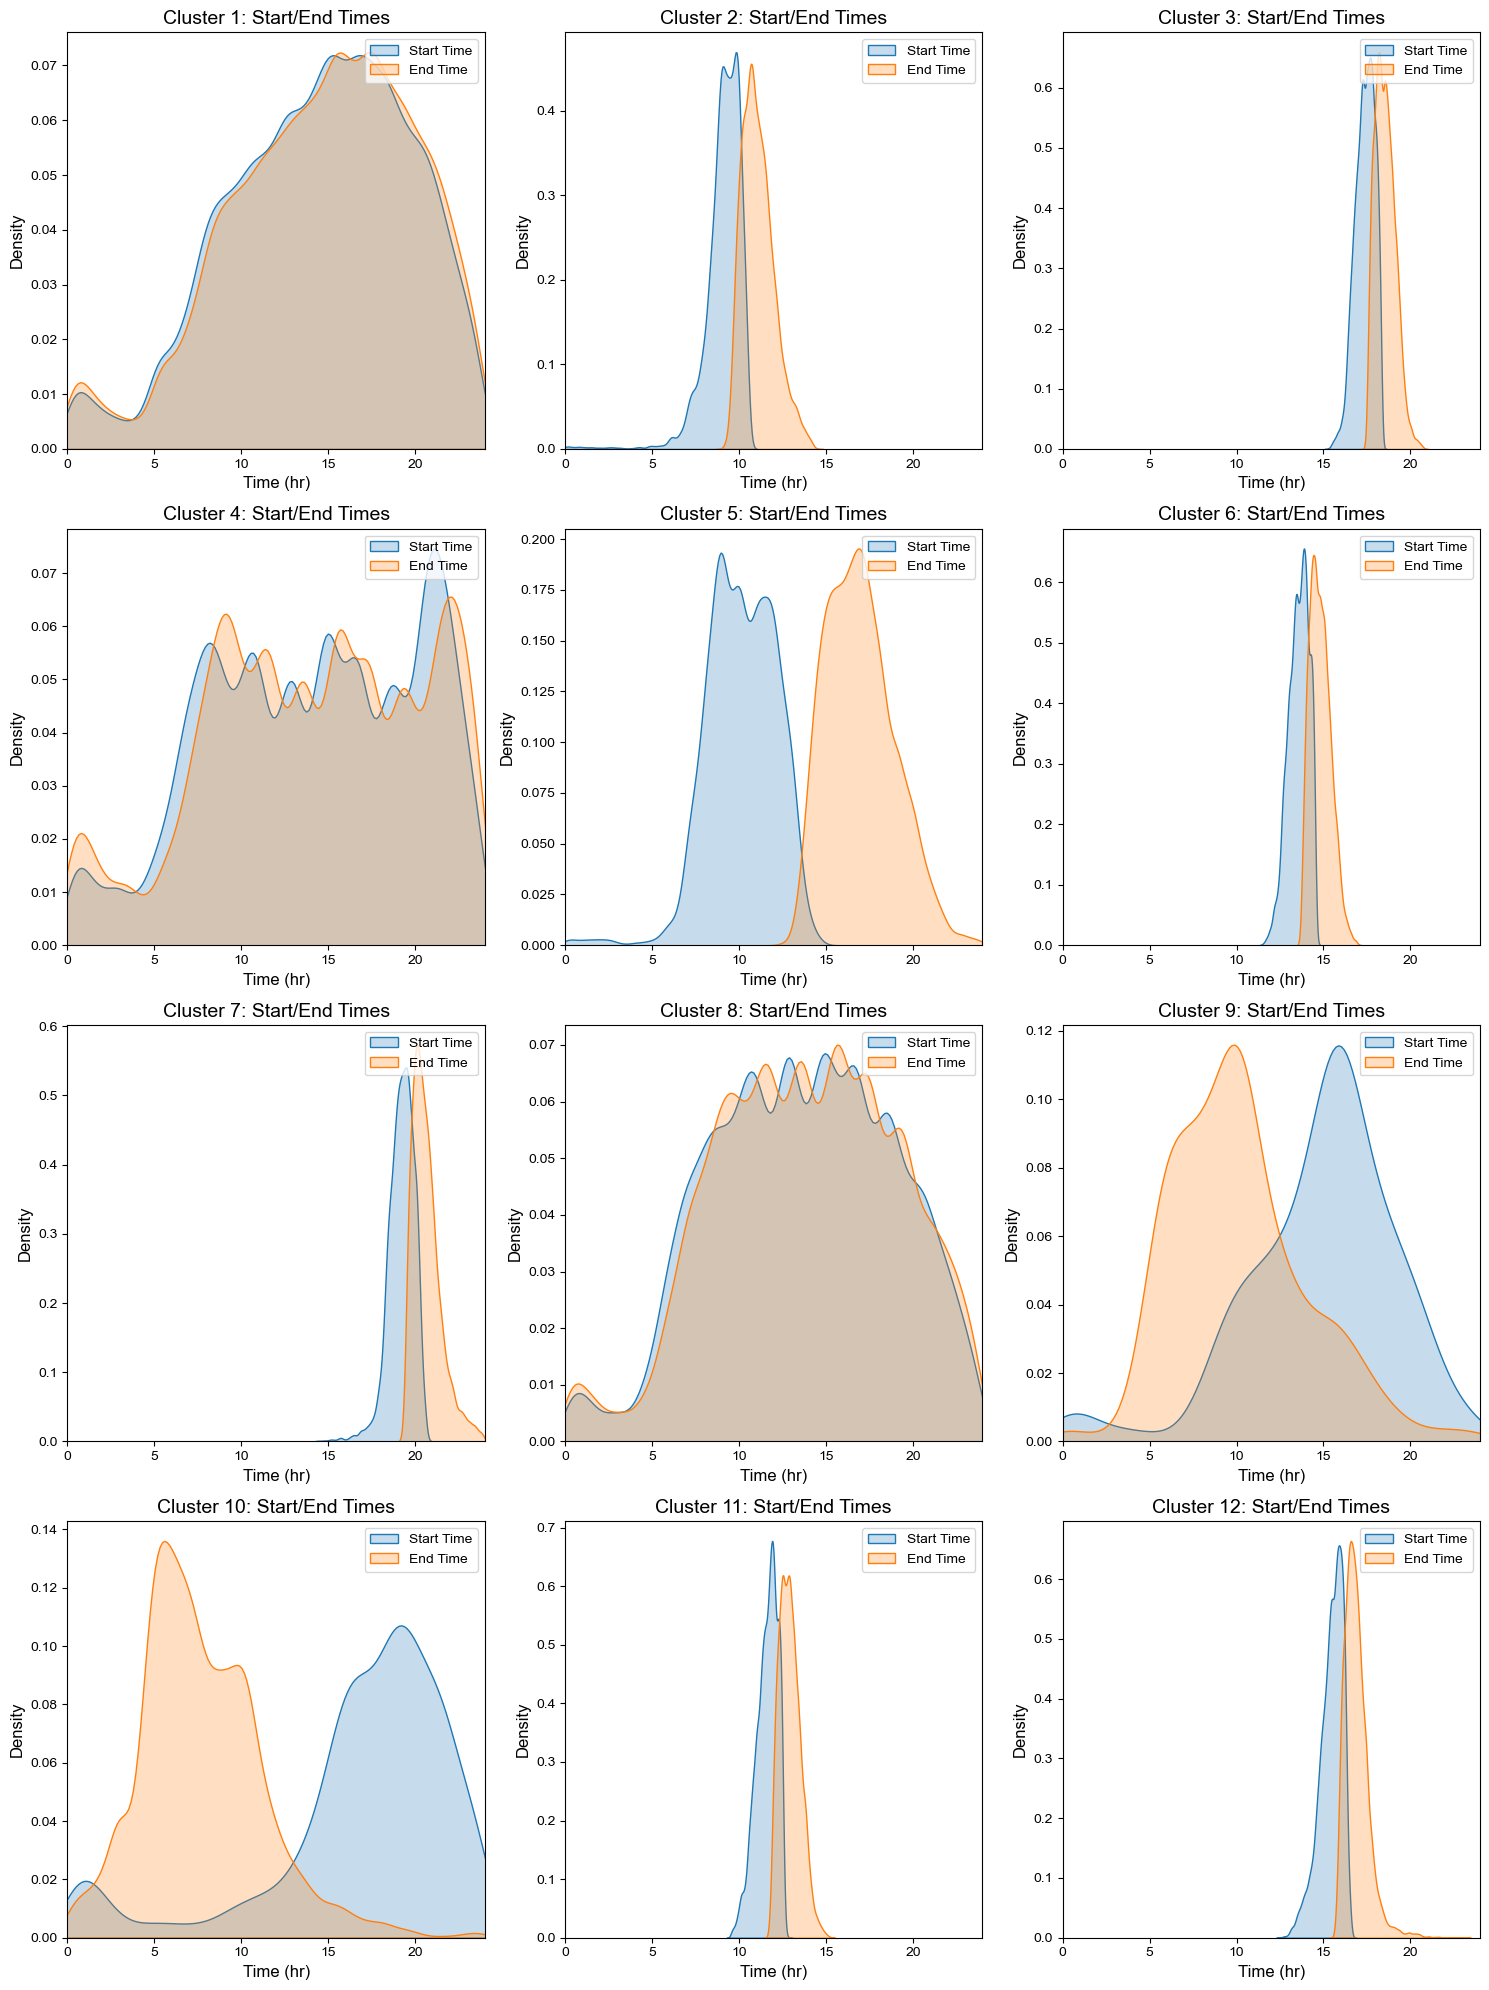

In [40]:


df_sesLA_enco_id_i_sums_norm_nclus = pd.DataFrame()
df_sesLA_enco_id_i_sums_norm_ntot = pd.DataFrame()


# Calculate the number of rows and columns for the subplot grid
nrows = int(np.ceil(k / 3))
ncols = 3 if k > 1 else 1

# Set up the figure for the grid of subplots
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, nrows * 5))

# Flatten the axes array for easy iteration (important for grids with more than one row)
axes = axes.flatten() if k > 1 else [axes]

for i in range(k):
    df_sesLA_id_i = df_sesLA_id[df_sesLA_id['cluster_id'] == i]
    
    # Kernel Density Plots
    sns.kdeplot(df_sesLA_id_i['start_time_2'], ax=axes[i], label='Start Time', fill=True)
    sns.kdeplot(df_sesLA_id_i['end_time_2'], ax=axes[i], label='End Time', fill=True)
    axes[i].set_xlabel('Time (hr)', fontsize=12)
    axes[i].set_ylabel('Density', fontsize=12)
    axes[i].set_title(f'Cluster {i+1}: Start/End Times', fontsize=14)
    axes[i].set_xlim(0, 24)
    axes[i].legend()
    
    # Proportion calculations can continue here or elsewhere as needed

# Turn off any unused subplots
for j in range(i + 1, nrows * ncols):
    fig.delaxes(axes[j])

# Adjust layout and save the figure
plt.tight_layout()
plt.savefig('figure5.2.png')

# Show the plot
plt.show()


# Charge Duration / Total Duration Ratio

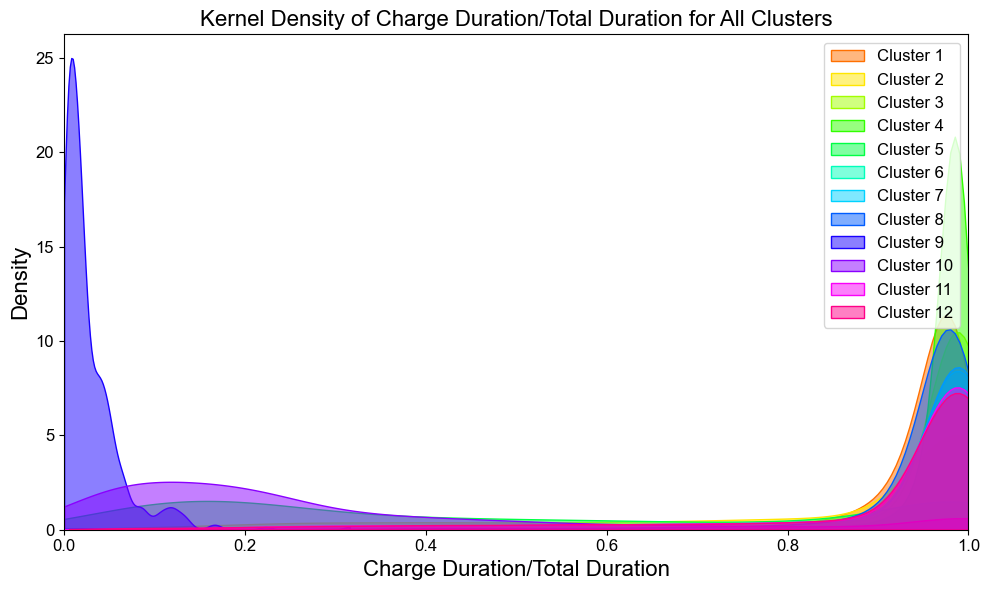

In [41]:

# Assuming df_sesLA_id is your DataFrame and 'cluster_id' is the column with cluster identifiers
df_sesLA_id['rat_duration'] = df_sesLA_id['charge_duration'] / df_sesLA_id['total_duration']


# Define a color palette (optional, for better visuals)
palette = sns.color_palette("hsv", k)

# Plotting
plt.figure(figsize=(10, 6))
for i in range(k):
    cluster_data = df_sesLA_id[df_sesLA_id['cluster_id'] == i]['rat_duration']
    sns.kdeplot(cluster_data, bw_method=0.2, fill=True, cut=0, alpha=0.5, label=f'Cluster {i+1}', color=palette[i])

plt.xlabel('Charge Duration/Total Duration', fontsize=16)
plt.ylabel('Density', fontsize=16)
plt.title('Kernel Density of Charge Duration/Total Duration for All Clusters', fontsize=16)
plt.xlim(0, 1)
plt.legend(fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.savefig('figure5.4.png')
plt.show()



# Start/ End SOC

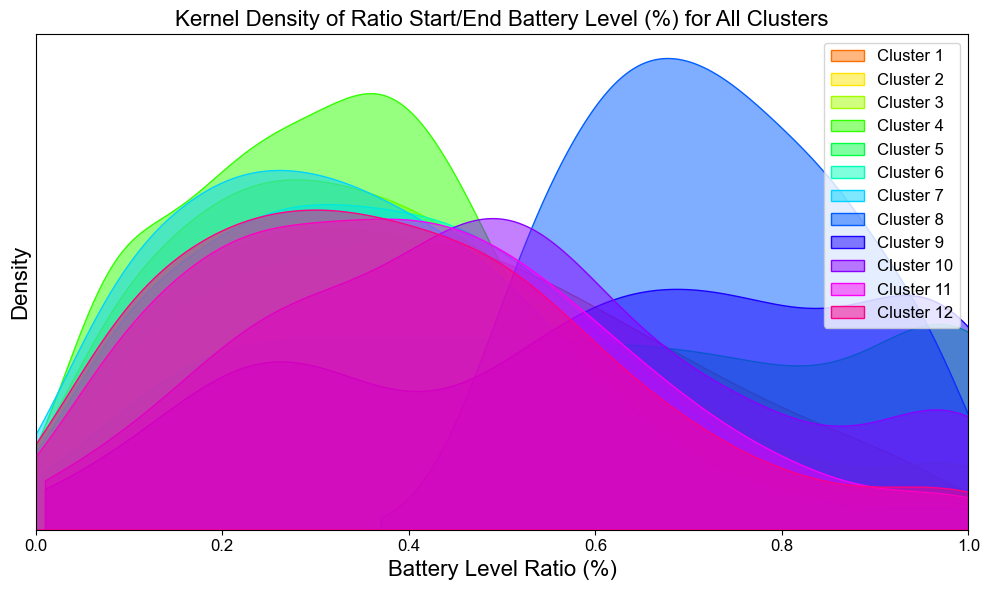

In [42]:

# Assuming df_sesLA_id is your DataFrame and 'cluster_id' is the column with cluster identifiers
df_sesLA_id['rat_soc'] = df_sesLA_id['start_soc'] / df_sesLA_id['end_soc']


# Define a color palette (optional, for better visuals)
palette = sns.color_palette("hsv", k)

# Plotting
plt.figure(figsize=(10, 6))
for i in range(k):
    cluster_data = df_sesLA_id[df_sesLA_id['cluster_id'] == i]['rat_soc']
    sns.kdeplot(cluster_data, bw_method=0.3, fill=True, cut=0, alpha=0.5, label=f'Cluster {i+1}', color=palette[i])

plt.xlabel('Battery Level Ratio (%)', fontsize=16)
plt.ylabel('Density', fontsize=16)
plt.title('Kernel Density of Ratio Start/End Battery Level (%) for All Clusters', fontsize=16)
plt.xlim(0, 1)
plt.legend(fontsize=12)
plt.xticks(fontsize=12)
plt.yticks([])
plt.tight_layout()
plt.savefig('figure5.3.png')
plt.show()


# Pricing Proportion across all Clusters

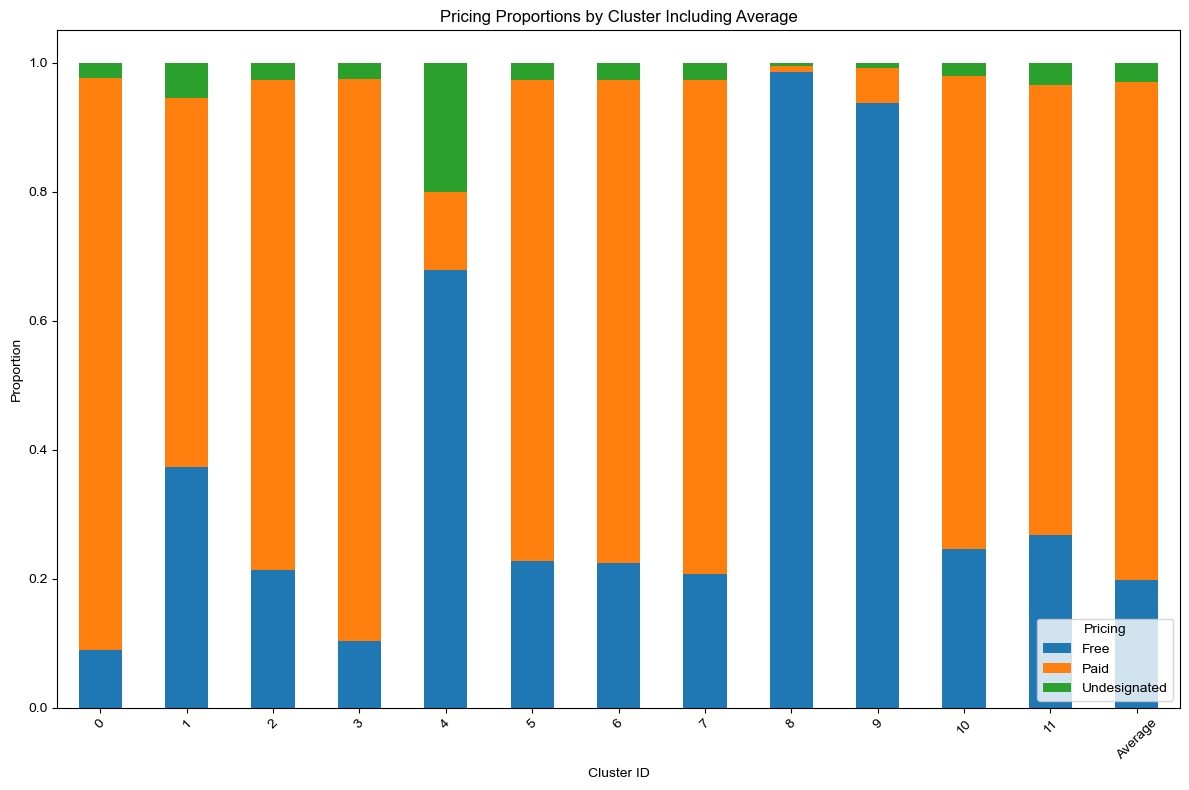

In [43]:
pricing_categories = ['Free', 'Paid', 'Undesignated']
average_proportions = df_sesLA['pricing'].value_counts(normalize=True)
n_clusters = k
# Calculate proportions for each cluster
pricing_proportions = pd.DataFrame(index=range(n_clusters), columns=pricing_categories)
for cluster_id in range(n_clusters):
    cluster_df = df_sesLA[df_sesLA['cluster_id'] == cluster_id]
    total_count = len(cluster_df)
    for pricing in pricing_categories:
        count = len(cluster_df[cluster_df['pricing'] == pricing])
        pricing_proportions.at[cluster_id, pricing] = count / total_count if total_count > 0 else 0

# Convert cluster proportions to numeric for plotting
pricing_proportions = pricing_proportions.apply(pd.to_numeric)

# Append average proportions to the cluster proportions DataFrame
pricing_proportions.loc['Average'] = average_proportions

# Plotting the stacked bar chart including the average
ax = pricing_proportions.plot(kind='bar', stacked=True, figsize=(12, 8))
ax.set_title('Pricing Proportions by Cluster Including Average')
ax.set_xlabel('Cluster ID')
ax.set_ylabel('Proportion')

cluster_ids = [str(i) for i in range(n_clusters)]  # Convert cluster ids to strings
cluster_ids.append('Average')  # Append 'Average' to the list
ax.set_xticklabels(cluster_ids, rotation=45)

plt.legend(title='Pricing')
plt.tight_layout()  # Adjust layout to make room for rotated x-axis labels
plt.savefig(f'figure5.6.png')
plt.show()



# Venue Proportion across Clusters

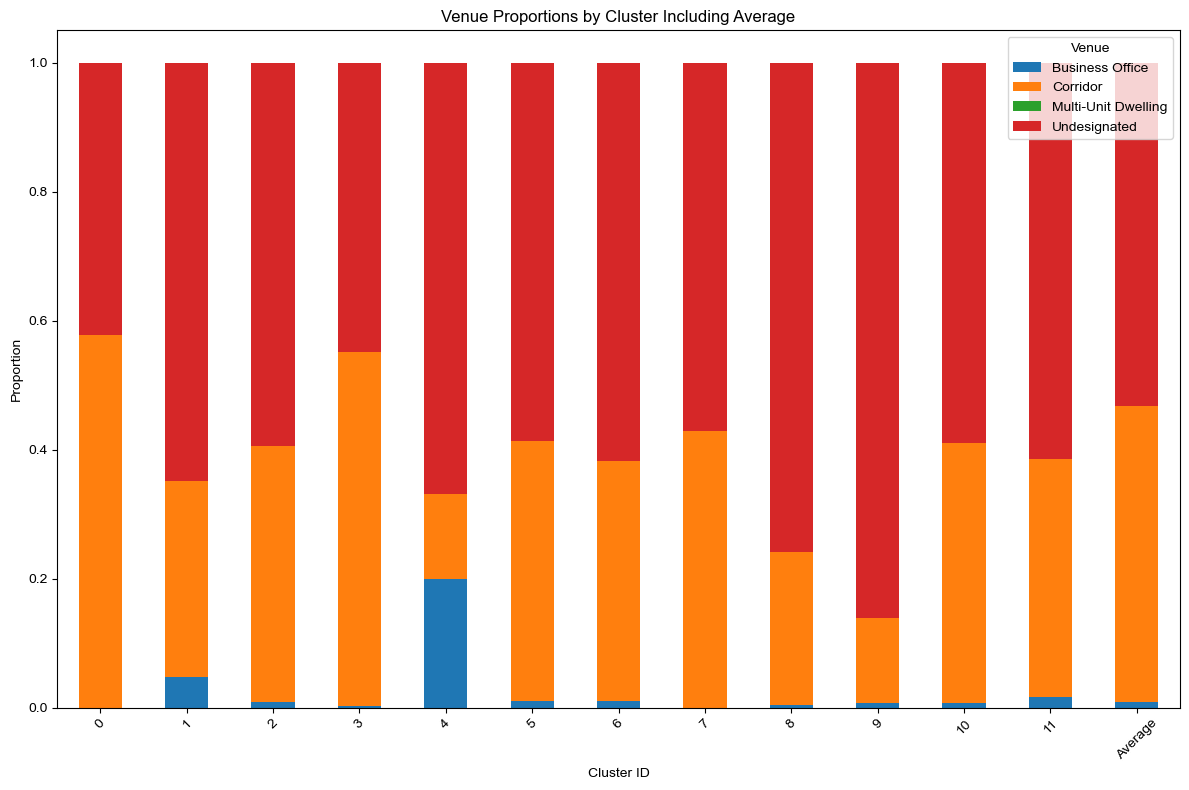

In [44]:

venues = ['Business Office', 'Corridor', 'Multi-Unit Dwelling', 'Undesignated']
n_clusters = k  # Assuming cluster_ids range from 0 to 8

# Initialize a DataFrame to hold proportions for each venue by cluster
venue_proportions = pd.DataFrame(index=range(n_clusters), columns=venues)

# Calculate proportions for each cluster
for cluster_id in range(n_clusters):
    cluster_df = df_sesLA[df_sesLA['cluster_id'] == cluster_id]
    total_count = len(cluster_df)
    for venue in venues:
        count = len(cluster_df[cluster_df['venue'] == venue])
        venue_proportions.at[cluster_id, venue] = count / total_count if total_count > 0 else 0

# Convert cluster proportions to numeric for plotting
venue_proportions = venue_proportions.apply(pd.to_numeric)

# Calculate the average proportions for the 'venue' column
average_venue_proportions = df_sesLA['venue'].value_counts(normalize=True)

# Append the average proportions to the cluster proportions DataFrame
venue_proportions.loc['Average'] = average_venue_proportions

# Plotting the stacked bar chart including the average
ax = venue_proportions.plot(kind='bar', stacked=True, figsize=(12, 8))
ax.set_title('Venue Proportions by Cluster Including Average')
ax.set_xlabel('Cluster ID')
ax.set_ylabel('Proportion')

cluster_ids = [str(i) for i in range(n_clusters)]  # Convert cluster ids to strings
cluster_ids.append('Average')  # Append 'Average' to the list
ax.set_xticklabels(cluster_ids, rotation=45)

#plt.xticks(list(range(9)) , rotation=45)  # Includes 'Average'
plt.legend(title='Venue')
plt.tight_layout()  # Adjust layout to make room for rotated x-axis labels
plt.savefig(f'figure5.5.png')
plt.show()
